In [250]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
from collections import Counter
%matplotlib inline
plt.style.use('ggplot')

In [5]:
fname = "top_rated_res_user.csv"
users = pd.read_csv(fname, sep = ",")

In [44]:
data = users.drop(['id', 'name', 'yelping_since'], axis=1)

In [45]:
cols = list(data.columns)
scaler = StandardScaler()
data[cols] = pd.DataFrame(scaler.fit_transform(data[cols]))

In [46]:
X = data.values
X.shape

(18591, 17)

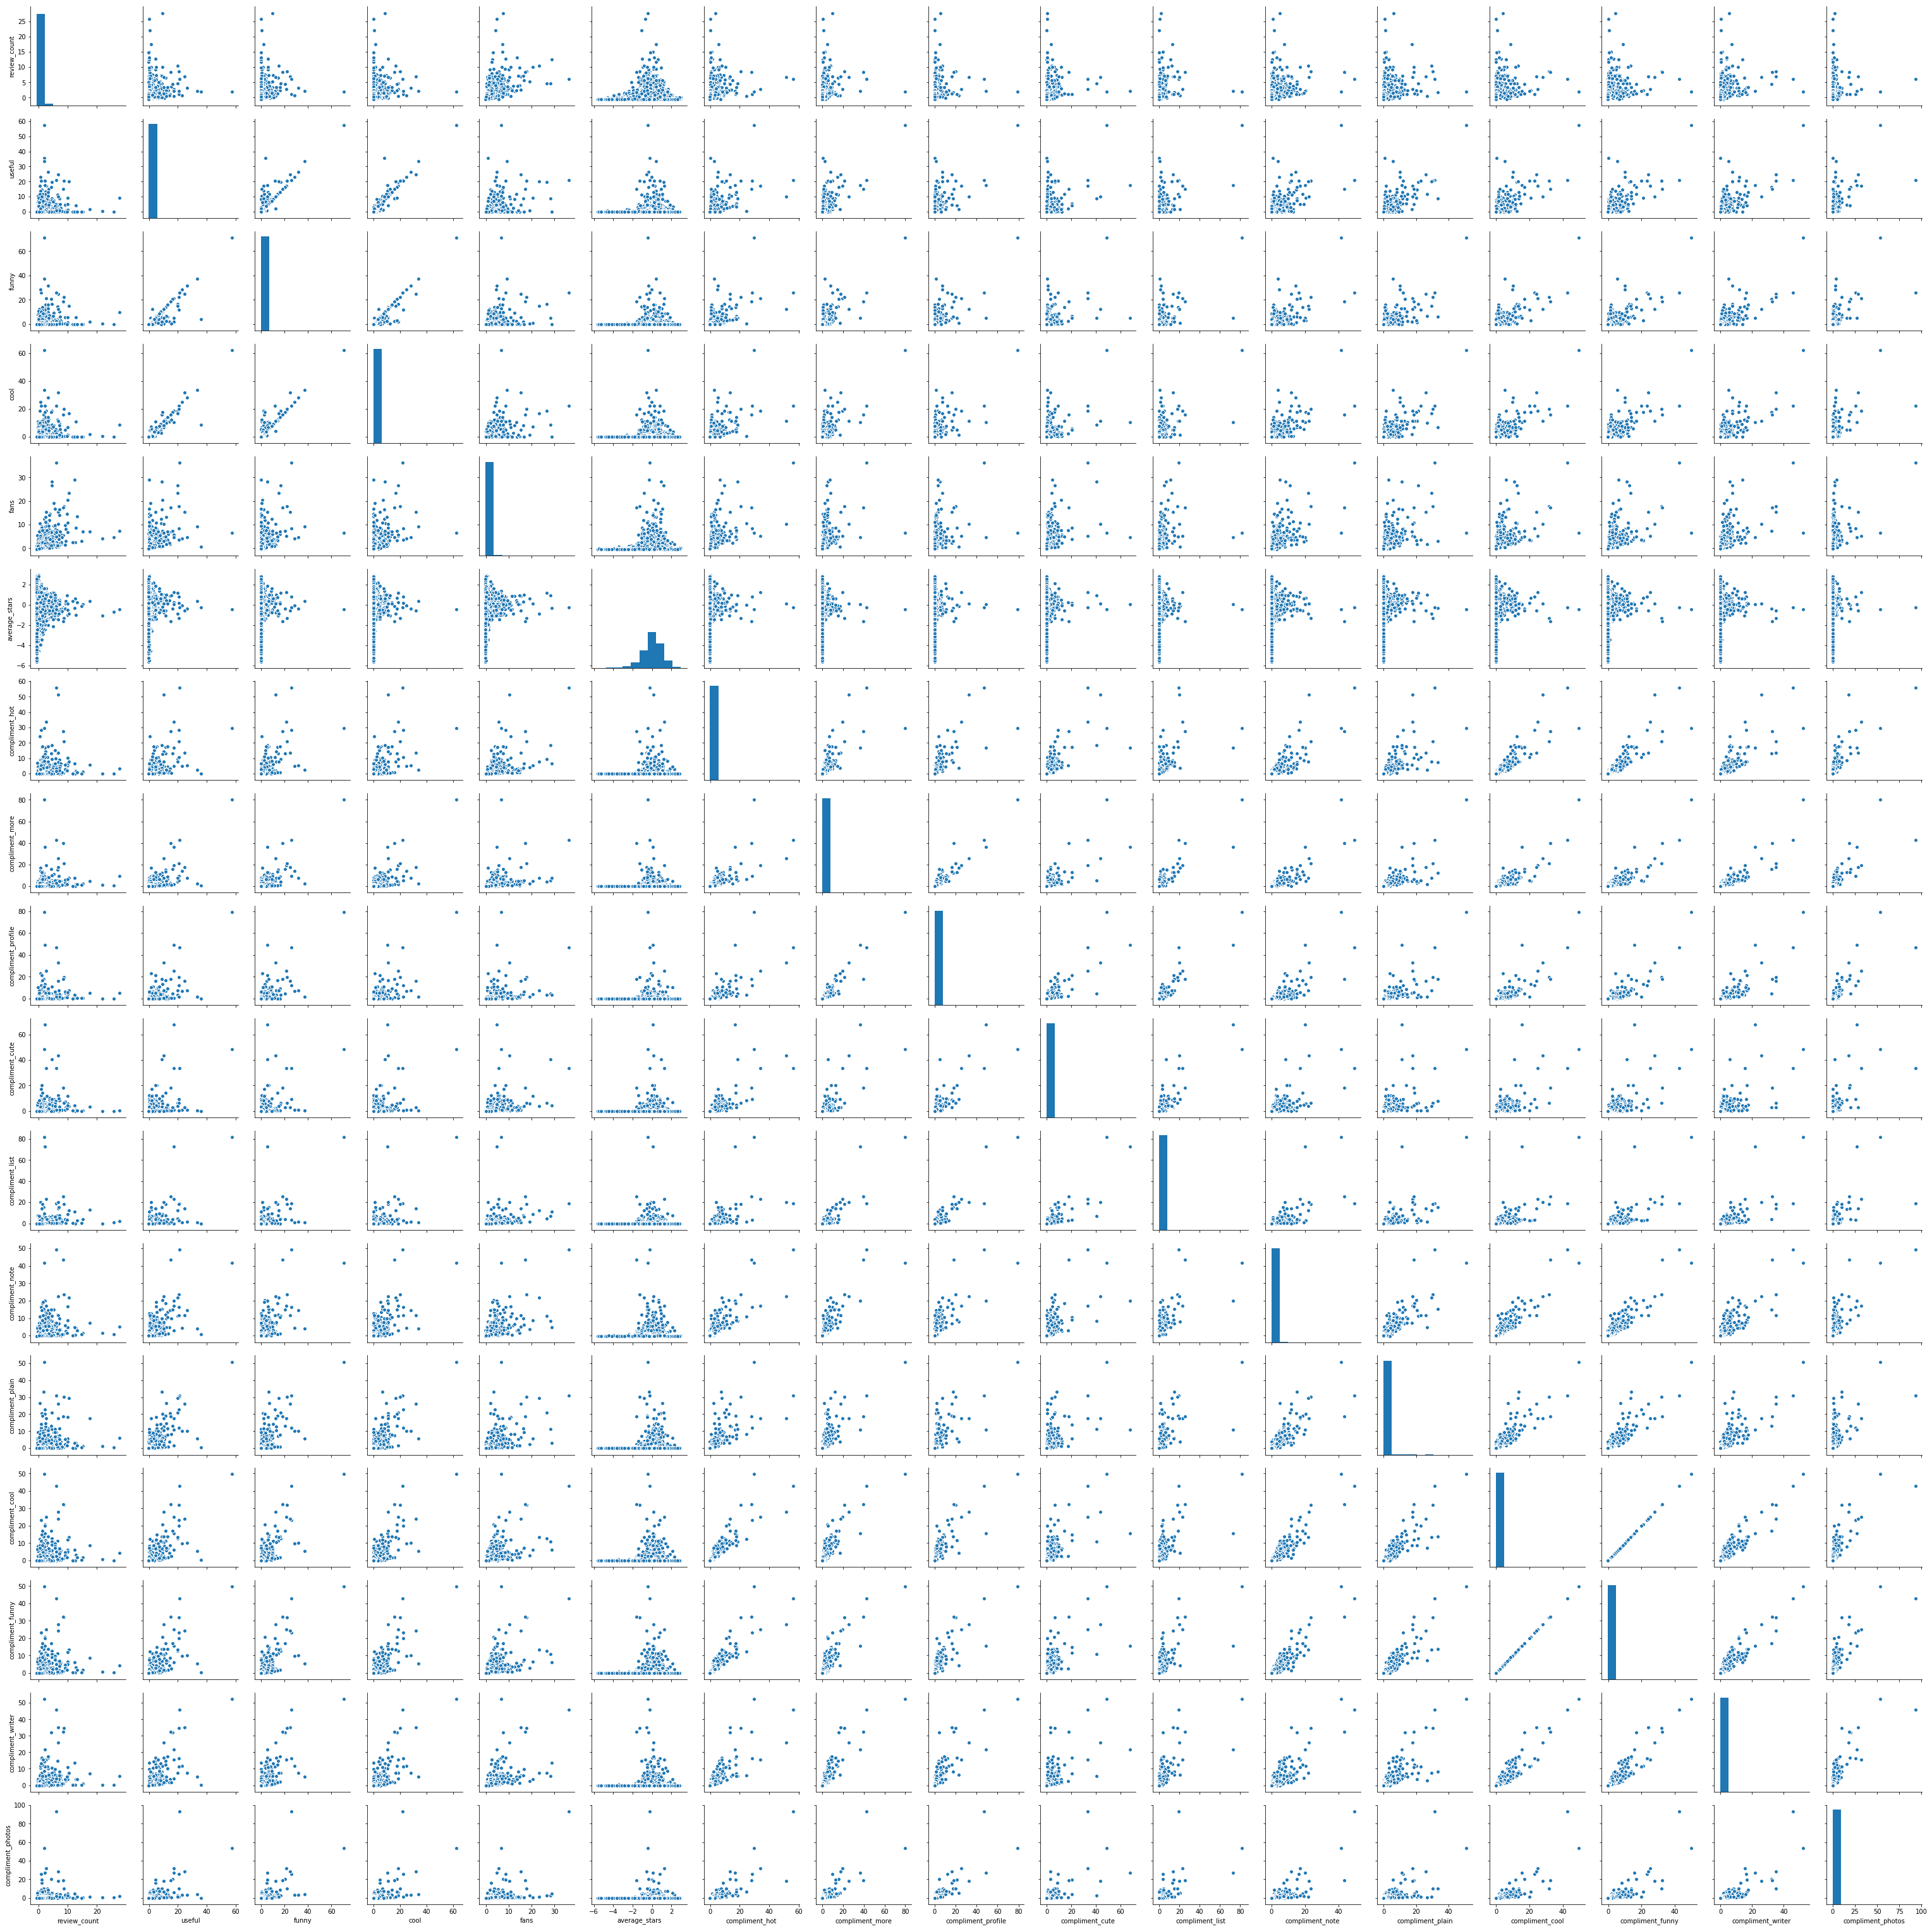

In [21]:
sns.pairplot(data)

In [198]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

In [321]:
def plot_cluster(cluster_, title='K-Means'):
    df_pca = pd.DataFrame(np.concatenate((X_pca, cluster_.reshape(X_pca.shape[0], 1)), axis=1), 
                          columns=['PCA 1', 'PCA 2', 'Influencer'])
    g = sns.lmplot(x='PCA 1', y='PCA 2', hue='Influencer', data=df_pca, fit_reg=False, legend_out=False)

    leg = g.axes.flat[0].get_legend()
    leg.set_title(title)
    new_labels = ['Non-Influencer', 'Influencer']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)
    plt.show()

**K-Means**

In [322]:
kmeans = KMeans(n_clusters=2, random_state=1)
clusters_kmeans = kmeans.fit_predict(X_pca)
print(Counter(clusters_kmeans))
outliers_kmeans = np.where(clusters_kmeans == 1)[0]

plot_cluster(clusters_kmeans)

Counter({0: 18564, 1: 27})


TypeError: lmplot() got an unexpected keyword argument 's'

**DBSCAN**

In [249]:
dbscan = DBSCAN(eps = 60, min_samples = 5, metric = 'cityblock')
clusters_dbscan = dbscan.fit_predict(X)
print(Counter(clusters_dbscan))
outliers_dbscan = np.where(clusters_dbscan == 1)[0]
plot_cluster(clusters_dbscan*(-1), 'DBSCAN')

Counter({0: 14002, -1: 4589})


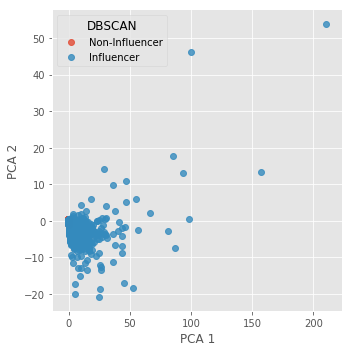

In [283]:
dbscan = DBSCAN(eps = 0.08, min_samples = 1000, metric = 'cosine')
clusters_dbscan = dbscan.fit_predict(X)
print(Counter(clusters_dbscan))
outliers_dbscan = np.where(clusters_dbscan == 1)[0]
plot_cluster(clusters_dbscan*(-1), 'DBSCAN')

Counter({0: 18571, 1: 20})


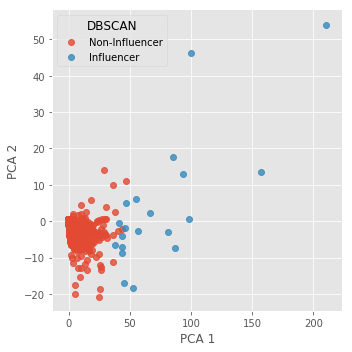

In [269]:
dbscan = DBSCAN(eps = 60, min_samples = 5, metric = 'cosine')
clusters_dbscan = dbscan.fit_predict(X)*(-1)
print(Counter(clusters_dbscan))
outliers_dbscan = np.where(clusters_dbscan == 1)[0]
plot_cluster(clusters_dbscan, 'DBSCAN')

**Local Outlier Factor**

In [337]:
lof = LocalOutlierFactor(n_neighbors=100, metric='cosine', contamination=0.1)
clusters_lof = np.array(list(map(lambda x: 1 if x==-1 else 0, lof.fit_predict(X_pca))))
print(Counter(clusters_lof))
outliers_lof = np.where(clusters_lof == 1)[0]
plot_cluster(clusters_lof, 'Local Outlier Factor')

Counter({0: 16731, 1: 1860})


TypeError: lmplot() got an unexpected keyword argument 's'

In [124]:
from sklearn.ensemble import IsolationForest
isof = IsolationForest(max_samples=100, random_state=1)
isof.fit(X)
clusters_isof = isof.predict(X)
Counter(clusters_isof)

Counter({-1: 1860, 1: 16731})

In [128]:
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(contamination=0.1)
ee.fit(X)
clusters_ee = ee.predict(X)
Counter(clusters_ee)

/Users/pulkitmaloo/anaconda3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/Users/pulkitmaloo/anaconda3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.235723137556477 > -264.729090465726358)
  % (det, previous_det), RuntimeWarning)
/Users/pulkitmaloo/anaconda3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.208905654088568 > -264.127344001821427)
  % (det, previous_det), RuntimeWarning)
/Users/pulkitmaloo/anaconda3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-247.759326258200360 > -262.959130436913597)
  % (det, previous_det), RuntimeWarning)
/Users/pulkitmaloo/anaconda3/lib/python3.6/site-pack

Counter({-1: 1859, 1: 16732})

In [85]:
files = glob.glob('top_reviews/*.html')
top_df_list = []
for file in tqdm(files):
    temp_df = pd.read_html(file, header=0)[0]
    top_df_list.append(temp_df)

100%|██████████| 5/5 [00:49<00:00,  9.96s/it]


In [87]:
files = glob.glob('low_reviews/*.html')
less_df_list = []
for file in tqdm(files):
    temp_df = pd.read_html(file, header=0)[0]
    less_df_list.append(temp_df)

100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


In [90]:
top_users = pd.read_csv("top_rated_res_user.csv", sep = ",")
top_users.shape

(18591, 20)

In [91]:
lesser_users = pd.read_csv("lesser_Review_users.csv", sep = ",")
lesser_users.shape

(6525, 20)

In [99]:
def get_rolling(users_df, df, thres = 30, outliers):
#     reviews = pd.read_html(file, header=0)[0]
    reviews = df.copy()
    reviews['date'] = pd.to_datetime(reviews['date'])
    reviews['year'], reviews['month'] = reviews['date'].dt.year, reviews['date'].dt.month
    reviews = reviews.sort_values(by=['date'])
    reviews['prev_date'] = reviews['date'] + pd.DateOffset(days=-thres)
    reviews['after_date'] = reviews['date'] + pd.DateOffset(days=thres)
    reviews['star_before'] = ''
    reviews['star_after'] = ''
    l1, l2 = [], []

    for i in range(reviews.shape[0]):
        before_date = reviews.iloc[i, :]['prev_date']
        curr_date = reviews.iloc[i, :]['date']
        after_date = reviews.iloc[i, :]['after_date']
        l1.append(reviews[(reviews['date']>=before_date) & (reviews['date']<curr_date)]['stars'].mean())
        l2.append(reviews[(reviews['date']>curr_date) & (reviews['date']<=after_date)]['stars'].mean())
    
    reviews["star_before"] = l1
    reviews["star_after"] = l2
    reviews['star_diff'] = reviews["star_after"] - reviews["star_before"]
    
    influencers_ids = list(users_df.iloc[outliers, :]['id'])
    influencers_reviews = reviews[reviews['user_id'].isin(influencers_ids)]
    influencers_reviews = influencers_reviews.dropna()
    return influencers_reviews['star_diff'].values
    

In [301]:
from scipy import stats
def t_testing(users_df, df_list, outliers, thresh = 30):
    ### rolling
    mean_diff = []
    for reviews_df in tqdm(df_list):
        mean_diff.append(get_rolling(users_df, reviews_df, thres, outliers))
    mean_diff_total = [j for i in mean_diff for j in i]
    
    ### do t-test
    from scipy import stats
    t = stats.ttest_1samp(mean_diff_total, 0)
    sigma  = np.std(mean_diff_total)
    n = len(mean_diff_total)
    mean = np.mean(mean_diff_total)
    conf_interval = stats.t.interval(alpha=0.98, loc = mean, scale=sigma/np.sqrt(n), df=n-1)
    conf_interval_len = conf_interval[1] - conf_interval[0]
    return (conf_interval_len, conf_interval, t.pvalue)

In [348]:
t_testing(top_users, top_df_list, outliers)

100%|██████████| 5/5 [00:55<00:00, 11.08s/it]


(0.11723627702353283,
 (0.0011889134989347266, 0.11842519052246755),
 0.018436804671446736)

In [346]:
ratio = users["useful"]#/users["review_count"]

In [347]:
outliers = ratio.iloc[ratio.argsort()][::-1].index[:50]

In [335]:
outliers_lof = lof.negative_outlier_factor_.argsort()[:200]

In [ ]:
# kmeans 
# DBSCAN - 3 params
# LOF
#### p-value for everyone